# Setup

In [1]:
import pandas as pd
from tqdm import tqdm
import re
import json
import nltk
import numpy as np
import matplotlib.pyplot as plt

from random import shuffle

from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import DataCollatorForLanguageModeling, AutoTokenizer, TFAutoModelForCausalLM, AdamWeightDecay
from os.path import join, exists

In [2]:
from lib.BBData import character_dict, model_name
from lib.BBDataLoad import dialogpt_preprocess_function, load_char_df, get_chatbot_predictions, merge_df_for_metrics

from lib.wip.frequency import sentence_preprocess, freq_pairwise_sim, filter_by_weights, get_word_frequency, get_tfidfs, FrequencyChatbotClassifier
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     c:\Users\User\anaconda3\envs\nlp\lib\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
characters = list(character_dict.keys())
# characters.remove('Default')

mass_value = 0.3

In [4]:
# Mount google drive, if in Colaboratory environment
import os
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    base_folder = '/content/drive/My Drive/unibo/NLP_project/BarneyBot'
    os.system("pip install datasets")
    os.system("pip install transformers")
    os.system("pip install rouge_score")
    os.system("pip install -U sentence-transformers")
else:
    # base_folder = os.getcwd()
    base_folder = '..'

out_folder = os.path.join(base_folder, 'Data', 'Characters')

# Data Loading

In [5]:
character_docs = dict()
for character in characters:
    if character == 'Default':
        df = pd.read_csv(os.path.join(out_folder, character, f'{character}.tsv'), 
                         names=[character, 'response'], sep='\t')
        df['response'] = df['response'].apply(lambda x: x[3:])
        df[character] = df[character].apply(lambda x: x[3:])
        character_docs[character] = df['response'].tolist()
    else:
        df = pd.read_csv(os.path.join(out_folder, character, f'{character}.csv'))
        character_docs[character] = df['response'].tolist()

In [6]:
for character in characters:
    for i in tqdm(range(len(character_docs[character]))):
        sentence, relevant = sentence_preprocess(character_docs[character][i])
        if relevant:
            character_docs[character][i] = sentence

100%|██████████| 737332/737332 [05:58<00:00, 2058.91it/s]


In [7]:
test_size = 0.33
character_docs_train = {}
character_docs_test = {}
for c in characters:
    shuffle(character_docs[c])
    end_idx = int(len(character_docs[c]) * test_size)
    character_docs_train[c] = character_docs[c][end_idx:]
    character_docs_test[c] = character_docs[c][:end_idx]

# Word Frequency

Loading word frequencies

In [8]:
"""wordfreqs_train = dict()
for character in tqdm(characters):
    wordfreqs_train[character] = get_word_frequency(' '.join(character_docs_train[character]), f_sorted=True)

wordfreqs_test = dict()
for character in tqdm(characters):
    wordfreqs_test[character] = get_word_frequency(' '.join(character_docs_test[character]), f_sorted=True)"""

"wordfreqs_train = dict()\nfor character in tqdm(characters):\n    wordfreqs_train[character] = get_word_frequency(' '.join(character_docs_train[character]), f_sorted=True)\n\nwordfreqs_test = dict()\nfor character in tqdm(characters):\n    wordfreqs_test[character] = get_word_frequency(' '.join(character_docs_test[character]), f_sorted=True)"

In [9]:
"""wordfreqs_reduced_train = dict()
for character in characters:
    wordfreqs_reduced_train[character] = filter_by_weights(wordfreqs_train[character], mass=0.3)

wordfreqs_reduced_test = dict()
for character in characters:
    wordfreqs_reduced_test[character] = filter_by_weights(wordfreqs_test[character], mass=0.3)"""

'wordfreqs_reduced_train = dict()\nfor character in characters:\n    wordfreqs_reduced_train[character] = filter_by_weights(wordfreqs_train[character], mass=0.3)\n\nwordfreqs_reduced_test = dict()\nfor character in characters:\n    wordfreqs_reduced_test[character] = filter_by_weights(wordfreqs_test[character], mass=0.3)'

Loading TF-IDF matrix

In [10]:
tfidf_vectorizer = TfidfVectorizer(input='content', stop_words='english')

In [11]:
tfidfs_train = get_tfidfs([' '.join(character_docs_train[character]) for character in characters], characters, tfidf_vectorizer)

In [12]:
tfidfs_reduced_train = dict()
for character in characters:
    tfidfs_reduced_train[character] = filter_by_weights(tfidfs_train[character], mass=mass_value)

# WordCloud Plot (Example)

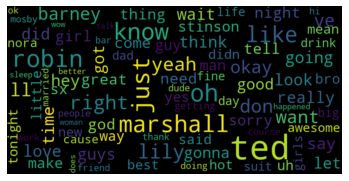

<Figure size 432x288 with 0 Axes>

In [13]:
from lib.BBVisualizations import BBVisualization
BBVisualization.load_visualization("wordcloud").plot(freqdict=tfidfs_reduced_train['Barney'])

# Frequency Pairwise Similarity (Example)

In [14]:
"""freq_pairwise_sim(wordfreqs_reduced_train['Fry'], wordfreqs_reduced_test['Fry'])"""

"freq_pairwise_sim(wordfreqs_reduced_train['Fry'], wordfreqs_reduced_test['Fry'])"

# Test Classifier Performances Against Test Set

In [15]:
"""wf_classifier = FrequencyChatbotClassifier(characters, mode='word frequency')
wf_classifier.train(list(character_docs_train.values()))

y_true = range(0, len(characters))
y_pred = [np.argmax(list(wf_classifier.predict(character_docs_test[character], mass=0.3).values()))
          for character in characters]

print('Word Frequency classifier test accuracy: {:.2f}'.format(
             sum([y_pred[i] == y_true[i] for i in range(len(y_true))]) / len(y_true)))
confusion_matrix(y_true, y_pred)"""

"wf_classifier = FrequencyChatbotClassifier(characters, mode='word frequency')\nwf_classifier.train(list(character_docs_train.values()))\n\ny_true = range(0, len(characters))\ny_pred = [np.argmax(list(wf_classifier.predict(character_docs_test[character], mass=0.3).values()))\n          for character in characters]\n\nprint('Word Frequency classifier test accuracy: {:.2f}'.format(\n             sum([y_pred[i] == y_true[i] for i in range(len(y_true))]) / len(y_true)))\nconfusion_matrix(y_true, y_pred)"

In [16]:
tfidf_classifier = FrequencyChatbotClassifier(characters, mode='tf-idf')
tfidf_classifier.train(list(character_docs_train.values()))

y_true = range(0, len(characters))
y_pred = [np.argmax(list(tfidf_classifier.predict(character_docs_test[character], mass=0.3)[0].values()))
          for character in characters]

print('TF-IDF classifier test accuracy: {:.2f}'.format(
             sum([y_pred[i] == y_true[i] for i in range(len(y_true))]) / len(y_true)))
confusion_matrix(y_true, y_pred)

TF-IDF classifier test accuracy: 1.00


array([[1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int64)

# Test Classifiers On Chatbots (Not Cached!)

In [17]:
tfidf_classifier = FrequencyChatbotClassifier(characters, mode='tf-idf')
tfidf_classifier.train(list(character_docs.values()))

In [18]:
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=join("..", "cache"))
tokenizer.pad_token = '#'
data_collator = DataCollatorForLanguageModeling(mlm=False, tokenizer=tokenizer, return_tensors='tf')

In [19]:
characters_noDefault = characters.copy()
characters_noDefault.remove('Default')

In [20]:
### create dataset
n_tests = 1
doc_test = []
batch_size = 8
override_predictions = False
predictions = {c:[] for c in characters}
raw_predictions = {c:[] for c in characters}
msw_predictions = {c:[] for c in characters}
print('Creating dataset...')
if n_tests > 1 and not override_predictions:
    raise Exception('must override previous predictions if you need more tests')

for i in range(n_tests):
    print(f'Run {i}/{n_tests}')
    for character in tqdm(characters_noDefault):
        character_checkpoint = join(out_folder, character, character_dict[character]['checkpoint_folder'])
        model_chatbot = TFAutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=character_checkpoint) if override_predictions else None
        if model_chatbot:
            model_chatbot.compile(optimizer=AdamWeightDecay(learning_rate=2e-5))

        character_hg = load_char_df(character, base_folder)
        # This transform in a sequence of tokens ours dataset
        tokenized_character_hg = character_hg.map(lambda row: dialogpt_preprocess_function(row, tokenizer), batched=False)

        # Define tensorflow datasets
        encoded_test_set = tokenized_character_hg["test"].to_tf_dataset(
            columns=["input_ids", "attention_mask", "labels"],
            shuffle=False,
            batch_size=batch_size,
            collate_fn=data_collator,
        )

        # Takes the testset as sample question 
        sample_questions = character_hg['test']['context/0']

        # Sampling generation method
        predictions_sampling = get_chatbot_predictions(
            sample_questions,
            model_chatbot,
            character_dict[character]['prediction_filename'] + '_sampling.json',
            "Sampling",
            character,
            tokenizer,
            base_folder,
            override_predictions=override_predictions
        )
                                                    
        sentences = merge_df_for_metrics(character_hg['test'], None, None, predictions_sampling, tokenizer)['prd_sampling'].tolist()
        sentences = [sentence_preprocess(s) for s in sentences]
        doc_test.append([s[0] for s in sentences if s[1]])

Creating dataset...
Run 0/1


  0%|          | 0/8 [00:00<?, ?it/s]Using custom data configuration default-d78476db32c8db98
Reusing dataset csv (cache\csv\default-d78476db32c8db98\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)
100%|██████████| 1/1 [00:00<00:00, 63.15it/s]
Loading cached split indices for dataset at cache\csv\default-d78476db32c8db98\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-651037d43e5e3dbd.arrow and cache\csv\default-d78476db32c8db98\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-7e4903d85e508b43.arrow
Loading cached split indices for dataset at cache\csv\default-d78476db32c8db98\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-1b018c4ce0c1ed8c.arrow and cache\csv\default-d78476db32c8db98\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-2cfa4b0ef22c9ad5.arrow
Loading cached processed dataset at cache\csv\default-d78476db32c8db98\0.0.0\433e0ccc46f9880962c

Loading predictions from stored file
Loaded predictions from stored file


 12%|█▎        | 1/8 [00:03<00:25,  3.63s/it]Using custom data configuration default-8207271dc09e0a46
Reusing dataset csv (cache\csv\default-8207271dc09e0a46\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)
100%|██████████| 1/1 [00:00<00:00, 67.42it/s]
Loading cached split indices for dataset at cache\csv\default-8207271dc09e0a46\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-46b6cd7566c1d243.arrow and cache\csv\default-8207271dc09e0a46\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-e3e40e36f25dded7.arrow
Loading cached split indices for dataset at cache\csv\default-8207271dc09e0a46\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-1774625d7360210c.arrow and cache\csv\default-8207271dc09e0a46\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-ad5b734370182aae.arrow
Loading cached processed dataset at cache\csv\default-8207271dc09e0a46\0.0.0\433e0ccc46f

Loading predictions from stored file
Loaded predictions from stored file


 25%|██▌       | 2/8 [00:08<00:27,  4.57s/it]Using custom data configuration default-5e8064f57286033a
Reusing dataset csv (cache\csv\default-5e8064f57286033a\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)
100%|██████████| 1/1 [00:00<00:00, 141.75it/s]
Loading cached split indices for dataset at cache\csv\default-5e8064f57286033a\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-2b86c587abd47c66.arrow and cache\csv\default-5e8064f57286033a\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-8919d70a4bf80eed.arrow
Loading cached split indices for dataset at cache\csv\default-5e8064f57286033a\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-4099b79485c950ea.arrow and cache\csv\default-5e8064f57286033a\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-cecb46b03995ab9b.arrow
Loading cached processed dataset at cache\csv\default-5e8064f57286033a\0.0.0\433e0ccc46

Loading predictions from stored file
Loaded predictions from stored file


 38%|███▊      | 3/8 [00:10<00:15,  3.18s/it]Using custom data configuration default-b35448ec5dd887ec
Reusing dataset csv (cache\csv\default-b35448ec5dd887ec\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)
100%|██████████| 1/1 [00:00<00:00, 92.80it/s]
Loading cached split indices for dataset at cache\csv\default-b35448ec5dd887ec\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-667383473c444f25.arrow and cache\csv\default-b35448ec5dd887ec\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-c520a8a264854da4.arrow
Loading cached split indices for dataset at cache\csv\default-b35448ec5dd887ec\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-b072a26900059a04.arrow and cache\csv\default-b35448ec5dd887ec\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-885672efcb78500c.arrow
Loading cached processed dataset at cache\csv\default-b35448ec5dd887ec\0.0.0\433e0ccc46f

Loading predictions from stored file
Loaded predictions from stored file


 50%|█████     | 4/8 [00:12<00:10,  2.62s/it]Using custom data configuration default-2a0884da2a86facc
Reusing dataset csv (cache\csv\default-2a0884da2a86facc\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)
100%|██████████| 1/1 [00:00<00:00, 117.24it/s]
Loading cached split indices for dataset at cache\csv\default-2a0884da2a86facc\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-4c59c8594ee83881.arrow and cache\csv\default-2a0884da2a86facc\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-979ea9e674132025.arrow
Loading cached split indices for dataset at cache\csv\default-2a0884da2a86facc\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-2cdb39c47142be86.arrow and cache\csv\default-2a0884da2a86facc\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-4b32be2eacb5d552.arrow
Loading cached processed dataset at cache\csv\default-2a0884da2a86facc\0.0.0\433e0ccc46

Loading predictions from stored file
Loaded predictions from stored file


 62%|██████▎   | 5/8 [00:14<00:07,  2.38s/it]Using custom data configuration default-3bee7e44262edb7f
Reusing dataset csv (cache\csv\default-3bee7e44262edb7f\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)
100%|██████████| 1/1 [00:00<00:00, 92.60it/s]
Loading cached split indices for dataset at cache\csv\default-3bee7e44262edb7f\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-96d0a5ba5e8fec42.arrow and cache\csv\default-3bee7e44262edb7f\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-1443283cf78ecd8c.arrow
Loading cached split indices for dataset at cache\csv\default-3bee7e44262edb7f\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-fe15dac5f93d7344.arrow and cache\csv\default-3bee7e44262edb7f\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-c4745ad835a23735.arrow
Loading cached processed dataset at cache\csv\default-3bee7e44262edb7f\0.0.0\433e0ccc46f

Loading predictions from stored file
Loaded predictions from stored file


 75%|███████▌  | 6/8 [00:15<00:04,  2.02s/it]Using custom data configuration default-b81141adc87b87bf
Reusing dataset csv (cache\csv\default-b81141adc87b87bf\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)
100%|██████████| 1/1 [00:00<00:00, 85.80it/s]
Loading cached split indices for dataset at cache\csv\default-b81141adc87b87bf\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-e2d3926d0ffd0fd3.arrow and cache\csv\default-b81141adc87b87bf\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-f888d4a055d9f5e2.arrow
Loading cached split indices for dataset at cache\csv\default-b81141adc87b87bf\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-682a04a266efce80.arrow and cache\csv\default-b81141adc87b87bf\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-13fca5dad2d5247a.arrow
Loading cached processed dataset at cache\csv\default-b81141adc87b87bf\0.0.0\433e0ccc46f

Loading predictions from stored file
Loaded predictions from stored file


 88%|████████▊ | 7/8 [00:18<00:02,  2.47s/it]Using custom data configuration default-48cc5f719001fd3a
Reusing dataset csv (cache\csv\default-48cc5f719001fd3a\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)
100%|██████████| 1/1 [00:00<00:00, 101.91it/s]
Loading cached split indices for dataset at cache\csv\default-48cc5f719001fd3a\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-16c140b5da191e7c.arrow and cache\csv\default-48cc5f719001fd3a\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-ed121df269d87298.arrow
Loading cached split indices for dataset at cache\csv\default-48cc5f719001fd3a\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-f4f26cbce3ecb27c.arrow and cache\csv\default-48cc5f719001fd3a\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-186da54849d8ccad.arrow
Loading cached processed dataset at cache\csv\default-48cc5f719001fd3a\0.0.0\433e0ccc46

Loading predictions from stored file
Loaded predictions from stored file


100%|██████████| 8/8 [00:23<00:00,  2.93s/it]


In [21]:
### prediction on last test
print('Classification...')
for c in tqdm(range(len(characters_noDefault))):
    prediction, msws = tfidf_classifier.predict(doc_test[c], mass=mass_value)
    raw_predictions[characters[c]].append(prediction)
    msw_predictions[characters[c]].append(msws)
    predictions[characters[c]].append(
        int(max(prediction, key=prediction.get) == characters[c])
    )

Classification...


100%|██████████| 8/8 [02:06<00:00, 15.83s/it]


In [22]:
raw_predictions

{'Barney': [{'Barney': 0.78300635943899,
   'Sheldon': 0.39705944387612546,
   'Harry': 0.30613045222591173,
   'Fry': 0.47947848053595993,
   'Bender': 0.5279603147782953,
   'Vader': 0.024668276074521295,
   'Joey': 0.5775909062067572,
   'Phoebe': 0.6605154960250631,
   'Default': 0.4616327413759421}],
 'Sheldon': [{'Barney': 0.30645568307287907,
   'Sheldon': 0.8369550711934086,
   'Harry': 0.167947399879039,
   'Fry': 0.2642218635623028,
   'Bender': 0.29809886633007343,
   'Vader': 0.016033823172964937,
   'Joey': 0.5787529705161285,
   'Phoebe': 0.6301987900135654,
   'Default': 0.3147045984317278}],
 'Harry': [{'Barney': 0.38736237828119413,
   'Sheldon': 0.2479470470284908,
   'Harry': 0.41660221218810667,
   'Fry': 0.42439588648581433,
   'Bender': 0.44081647210136055,
   'Vader': 0.0,
   'Joey': 0.27909861337183983,
   'Phoebe': 0.2863954527511974,
   'Default': 0.4348371755120003}],
 'Fry': [{'Barney': 0.401968778297223,
   'Sheldon': 0.2795776319649572,
   'Harry': 0.27949

In [23]:
msw_predictions

{'Barney': [{'Barney': ['right',
    'guys',
    'll',
    'don',
    'hey',
    'did',
    'come',
    'want',
    'okay',
    'time',
    'yeah',
    'mean',
    'lily',
    'life',
    'believe'],
   'Sheldon': ['did',
    'right',
    'want',
    'time',
    'believe',
    'think',
    'come',
    'mean',
    'life',
    'hey',
    'like',
    'oh',
    'okay',
    'yeah',
    'sorry'],
   'Harry': ['did',
    'mean',
    'll',
    'think',
    'like',
    'okay',
    've',
    'don',
    'right',
    'come',
    'know',
    'just'],
   'Fry': ['did',
    'yeah',
    've',
    'mean',
    'come',
    'life',
    'don',
    'll',
    'want',
    'think',
    'believe',
    'right',
    'guys',
    'time',
    'gonna'],
   'Bender': ['come',
    'yeah',
    'life',
    'don',
    'mean',
    'time',
    'guys',
    'did',
    've',
    'right',
    'oh',
    'want',
    'think',
    'just',
    'gonna'],
   'Vader': ['want', 'don'],
   'Joey': ['did',
    'guys',
    'want',
    'com

In [24]:
predictions

{'Barney': [1],
 'Sheldon': [1],
 'Harry': [0],
 'Fry': [0],
 'Bender': [1],
 'Vader': [0],
 'Joey': [0],
 'Phoebe': [1],
 'Default': []}

In [25]:
raw_predictions.pop('Default')
predictions.pop('Default')

[]

In [26]:
print('TF-IDF classifier test accuracy: {:.2f}'.format(sum([char_pred[-1] for char_pred in predictions.values()])/len(predictions)))

TF-IDF classifier test accuracy: 0.50


In [27]:
### save predictions
append_predictions = True
override_predictions = False
predictions_file = join('..', 'metrics', 'tfidf_predictions.json')

if append_predictions and exists(predictions_file):
    with open(predictions_file, 'r', encoding='utf-8') as file:
        predictions_dict = json.load(file)
elif override_predictions or not exists(predictions_file):
    predictions_dict = {'one_hot':{c:[] for c in characters}, 'raw_predictions': {c:[] for c in characters}}
else:
    raise NotImplementedError
    
for c in characters_noDefault:
    predictions_dict['one_hot'][c] += predictions[c]
    predictions_dict['raw_predictions'][c] += raw_predictions[c]

with open(predictions_file, 'w', encoding='utf-8') as file:
    json.dump(predictions_dict, file)

In [28]:
predictions_dict

{'one_hot': {'Barney': [1, 1, 1, 1],
  'Sheldon': [1, 1, 1, 1],
  'Harry': [1, 0, 0, 0],
  'Fry': [0, 0, 0, 0],
  'Bender': [0, 1, 1, 1],
  'Vader': [1, 0, 0, 0],
  'Joey': [0, 0, 0, 0],
  'Phoebe': [1, 1, 1, 1]},
 'raw_predictions': {'Barney': [{'Barney': 0.7427531645309138,
    'Sheldon': 0.3409307888725184,
    'Harry': 0.24635663538513103,
    'Fry': 0.4365837899414391,
    'Bender': 0.4690792107496431,
    'Vader': 0.016606825033575093,
    'Joey': 0.5216851304420018,
    'Phoebe': 0.5625899764181352},
   {'Barney': 0.78300635943899,
    'Sheldon': 0.3970594438761256,
    'Harry': 0.30613045222591173,
    'Fry': 0.47947848053595993,
    'Bender': 0.5279603147782952,
    'Vader': 0.024668276074521298,
    'Joey': 0.5775909062067571,
    'Phoebe': 0.6605154960250631,
    'Default': 0.46163274137594223},
   {'Barney': 0.78300635943899,
    'Sheldon': 0.3970594438761256,
    'Harry': 0.30613045222591173,
    'Fry': 0.47947848053595993,
    'Bender': 0.5279603147782952,
    'Vader': 0.